# 🚀 NFL training and inference YOLOv5

### Hi kagglers, This is `Training` notebook using `YOLOv5`.


### Other notebooks in the competition
- [NFL Extra Images Detectron2 [Training]](https://www.kaggle.com/ammarnassanalhajali/training-nfl-extra-images-detectron2)
- [NFL Big Data Bowl 2021:Animating Players](https://www.kaggle.com/ammarnassanalhajali/nfl-big-data-bowl-2021-animating-players)


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# 📚 YOLOv5
YOLO, "You Only Look Once", has a long and succesful history with real time object detection.

#  ⬇️ Download YOLOv5
Clone this repo and install requirements.txt dependencies, including Python>=3.8 and PyTorch>=1.7.

In [ ]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

# Install dependencies
%pip install -qr requirements.txt  

# change directory
%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# 🔨 Weights & Biases
* Weights & Biases is a set of tools that tracks machine learning experiments, visualizes metrics, and shares results.
* Weights & Biases is directly integrated into YOLOv5, providing experiment metric tracking, model and dataset versioning, rich model prediction visualization, and more.

In [ ]:
# Install W&B 
!pip install -q --upgrade wandb

# Login 
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient() 

personal_key_for_api = user_secrets.get_secret("kk")

! wandb login $personal_key_for_api

# ☀️ Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import gc
import cv2
from IPython.core.display import Video, display
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
import subprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from IPython.core.magic import register_line_cell_magic

from os import listdir
from os.path import isfile, join
from glob import glob
import yaml

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

# 🍘 Hyperparameters

In [ ]:
Selected_fold=1
BATCH_SIZE = 16
EPOCHS = 35
IMG_SIZE=736

# 🍮 Loading Data

In [ ]:
# --- Read data ---
TRAIN_PATH = '/kaggle/input/nfl-health-and-safety-helmet-assignment/images/'
# Read in the data CSV files
train_df = pd.read_csv("/kaggle/input/nfl-health-and-safety-helmet-assignment/image_labels.csv")
#train_df=train_df.head(n=5000)
print('Number of ground truth bounding boxes: ', len(train_df))
# Number of unique labels

category_name_to_id  = {label: i for i, label in enumerate(train_df.label.unique())}
print('Classes_id: ', category_name_to_id )

Classes=['Helmet','Helmet-Blurred','Helmet-Difficult','Helmet-Sideline','Helmet-Partial']
print('Classes: ', Classes )

In [ ]:
train_meta=train_df.drop_duplicates(subset=['image'])
train_meta.reset_index(inplace = True)
train_meta["split"]="train"
train_meta.head()

# 🍚 Splitting Dataset

In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold
sfolder = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
X = train_meta[['image']]
y = train_meta[['label']]

fold_no = 1
for train, valid in sfolder.split(X,y):
    if fold_no==Selected_fold:
        train_meta.loc[valid, "split"] = "valid"
    fold_no += 1
     
train_meta.head()

In [ ]:
print("Dataset Size:",len(train_meta),
      "Training Images:", len(train_meta[train_meta.split=='train']),
      "Validation Images:",len(train_meta[train_meta.split=='valid']))

## 🍚 Organize Directories

I organized train and val images and labels according to the example below.

```
/Kaggle/working
    /NFL
         /images
             /train/img0.jpg
             /val
         /labels
             /train/img0.txt
             /val
    /yolov5
```

In [ ]:
os.makedirs('NFL/images/train', exist_ok=True)
os.makedirs('NFL/images/valid', exist_ok=True)
os.makedirs('NFL/labels/train', exist_ok=True)
os.makedirs('NFL/labels/valid', exist_ok=True)

In [ ]:
for i in tqdm(range(len(train_meta))):
    row = train_meta.loc[i]
    if row.split == 'train':
        copyfile(f'{TRAIN_PATH}{row.image}', f'NFL/images/train/{row.image}')
    else:
        copyfile(f'{TRAIN_PATH}{row.image}', f'NFL/images/valid/{row.image}') 

# 🍜 Create `Data.YAML` file

The `data.yaml`, is the dataset configuration file that defines:

1. the dataset root directory and relative paths to train/val/test image directories (or paths to *.txt files with image paths).
1. the number of classes.
1. a list of class names.

> 📍 Note: The `data.yaml` is created in the `yolov5/data` directory as required. 

In [ ]:
with open('/kaggle/working/NFL/train.txt', 'w') as f:
    for path in glob('/kaggle/working/NFL/images/train/*'):
        f.write(path+'\n')
            
with open('/kaggle/working/NFL/val.txt', 'w') as f:
    for path in glob('/kaggle/working/NFL/images/val/*'):
        f.write(path+'\n')

data = dict(
    train = '/kaggle/working/NFL/images/train',
    val = '/kaggle/working/NFL/images/valid',
    
    nc    = 5, # number of classes
    names = Classes # classes
    )

with open('/kaggle/working/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

%cat /kaggle/working/yolov5/data/data.yaml

In [ ]:
!ls '/kaggle/working/yolov5/data'

## 🍮 Create Labels for YOLOv5

To label your images,a `.txt` file with the same name of the image,will be created (if no objects in image, no *.txt file is required)
The *.txt file specifications are:

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

> 📍 Note: We don't have to remove the images without bounding boxes from the training or validation sets. 

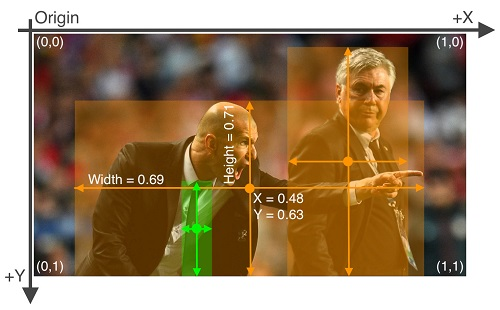

The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):

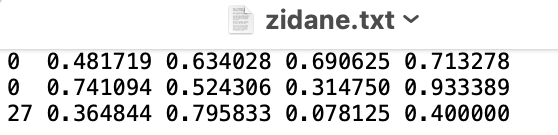

In [ ]:
# Get the raw bounding box by parsing the row value of the label column.
def get_bbox(row):
    bboxes = []
    bbox = []
    
    b1=float(row.left) 
    b2=float(row.width)  
    b3=float(row.top)
    b4=float(row.height) 
    
    x_min=b1  
    y_min=b3   
    x_max=b1+b2    
    y_max=b3+b4 
    
    bbox.append(float(x_min))
    bbox.append(float(y_min))
    bbox.append(float(x_max))
    bbox.append(float(y_max))
    bboxes.append(bbox)
    
    
    return bboxes


# Scale the bounding boxes according to the size of the resized image. 
def scale_bbox(row, bboxes,w,h):
    # Get scaling factor
    scale_x = IMG_SIZE/w
    scale_y = IMG_SIZE/h
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = float(bbox[0]*scale_x)
        y = float(bbox[1]*scale_y)
        x1 = float(bbox[2]*(scale_x))
        y1= float(bbox[3]*scale_y)

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes

# Convert the bounding boxes in YOLO format.
def get_yolo_format_bbox(img_w, img_h, bboxes):
    yolo_boxes = []
    for bbox in bboxes:
        w = bbox[2] - bbox[0] # xmax - xmin
        h = bbox[3] - bbox[1] # ymax - ymin
        xc = bbox[0] + float(w/2) # xmin + width/2
        yc = bbox[1] + float(h/2) # ymin + height/2
        
        yolo_boxes.append([xc/img_w, yc/img_h, w/img_w, h/img_h]) # x_center y_center width height
    
    return yolo_boxes

In [ ]:
for i in tqdm(range(len(train_meta))):
    row = train_meta.loc[i]
    # Get image
    image_name = row.image
    
    img = cv2.imread(TRAIN_PATH+image_name)
    
    height, width, _ = img.shape 

    image_n = image_name[:-4]
    # Get split
    split = row.split
    # Get  label id
    #label = category_name_to_id [row.label]
    if row.split=='train':
        file_name = f'/kaggle/working/NFL/labels/train/{image_n}.txt'
    else:
        file_name = f'/kaggle/working/NFL/labels/valid/{image_n}.txt'

    with open(file_name, 'w') as f:
        for index2, row1 in train_df.query("image == @image_name").iterrows():

            label = category_name_to_id[row1.label]
            bboxes = get_bbox(row1)
            # Scale bounding boxes
            scale_bboxes = scale_bbox(row1, bboxes,width, height)
            # Format for YOLOv5
            yolo_bboxes = get_yolo_format_bbox(IMG_SIZE, IMG_SIZE, scale_bboxes)
            for bbox in yolo_bboxes:
                bbox = [label]+bbox
                bbox = [str(i) for i in bbox]
                bbox = ' '.join(bbox)
                f.write(bbox)
                f.write('\n')

In [ ]:
import os
list = os.listdir("/kaggle/working/NFL/labels/train/") # dir is your directory path
number_files = len(list)
print(number_files)

#%cat /kaggle/working/NFL/labels/train/57503_003731_Sideline_frame428.txt

# Select a Model
Select a pretrained model to start training from. 
* Here we select YOLOv5s, the smallest and fastest model available.
* I will try YOLO5m

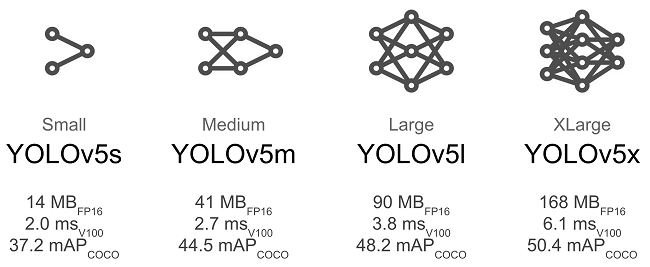

# 🚅 Train with W&B

In [ ]:
%cd yolov5/

All training results are saved to runs/train/ with incrementing run directories, i.e. runs/train/exp2, runs/train/exp3 etc. 

In [ ]:
#best_weights = '/kaggle/input/nfl-weights/yolov5/kaggle-NFL/exp/weights/best.pt' --weights {best_weights} \
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --project kaggle-NFL \
                 --cache

# Removing Files

In [ ]:
%cd "../"
path = "NFL"
shutil.rmtree(path)

### Class Distribution

In [ ]:
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/labels.jpg'));


### Batch Image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/train_batch0.jpg'))


## P Curve

In [ ]:
#!ls /kaggle/working/yolov5/kaggle-NFL/exp
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/P_curve.png'));

## PR Curve

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/PR_curve.png'));

## F1 Curve

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/F1_curve.png'));

## R Curve

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/R_curve.png'));

### GT Vs Pred

In [ ]:
ig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'/kaggle/working/yolov5/kaggle-NFL/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/kaggle/working/yolov5/kaggle-NFL/exp/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'/kaggle/working/yolov5/kaggle-NFL/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/kaggle/working/yolov5/runs/kaggle-NFL/val_batch{row}_pred.jpg', fontsize = 12)

### (Loss, Map) Vs Epoch


In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/results.png'));

### Confusion Matrix

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-NFL/exp/confusion_matrix.png'));

# inference

### Display video

In [ ]:
ex_video = '/kaggle/input/nfl-health-and-safety-helmet-assignment/test/58102_002798_Endzone.mp4'

frac = 0.6
display(Video(ex_video, embed=True, height=int(720*frac), width=int(1280*frac)))

### Create frames from video

In [ ]:
img_ext = 'png'
image_name = '58102_002798_Endzone'
frame_dir = '/kaggle/worling/NFL/mp4_img/'

os.makedirs(frame_dir, exist_ok=True)
cmd = 'ffmpeg -i \"{}\" -qscale:v 2 \"{}/{}_%d.{}\"'.format(ex_video, frame_dir, image_name, img_ext)
print(cmd)
subprocess.call(cmd, shell=True)

In [ ]:
%cd yolov5/

# Detecting

In [ ]:
best_w = '/kaggle/working/yolov5/kaggle-NFL/exp/weights/best.pt' #New
#best_w='/kaggle/input/nfl-weights/yolov5/kaggle-NFL/exp/weights/best.pt' # last
IMG_S=720

project_name = '58102_002798_Endzone'

!python detect.py --weights {best_w} \
                  --source {frame_dir} \
                  --img {IMG_S} \
                  --save-txt \
                  --save-conf \
                  --project {project_name}

### make video from frames

In [ ]:
video_name = '58102_002798_Endzone_fps50.mp4'

tmp_video_path = os.path.join('/kaggle/working/', f'tmp_{video_name}')
video_path = os.path.join('/kaggle/working/', video_name)

frame_rate = 60

images = [img for img in os.listdir(f'{project_name}/exp')]
images.remove('labels')
images.sort(key = lambda x: int(x.split('_')[-1][:-4]))

frame = cv2.imread(os.path.join('58102_002798_Endzone/exp', images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(tmp_video_path, cv2.VideoWriter_fourcc(*'MP4V'),
                        frame_rate, (width,height))

for f in images:
    img = cv2.imread(os.path.join('58102_002798_Endzone/exp', f))
    video.write(img)

video.release()

# Not all browsers support the codec, we will re-load the file at tmp_video_path
# and convert to a codec that is more broadly readable using ffmpeg

if os.path.exists(video_path):
    os.remove(video_path)
    
subprocess.run(["ffmpeg", "-i", tmp_video_path, "-crf", "18", "-preset", "veryfast",
                "-vcodec","libx264", video_path,])

os.remove(tmp_video_path)

In [ ]:
frac = 0.60
display(Video(video_path, embed=True, height=int(720*frac), width=int(1280*frac)))

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

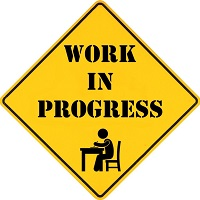

# References

1. https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
1. https://www.kaggle.com/eneszvo/yolov5-helmet-detection-train-and-inference
1. https://ultralytics.com/yolov5
1. https://docs.wandb.ai/
1. https://www.kaggle.com/ayuraj/train-covid-19-detection-using-yolov5
1. https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-train